SIN-393 - Introduction to Computer Vision (2023-2)

# Lecture 08 - Part 1 - Object detection

Prof. João Fernando Mari ([*joaofmari.github.io*](https://joaofmari.github.io/))

---

* Based on the tutorial:
    * Adrian Rosebrock. ***PyTorch object detection with pre-trained networks.***
        * https://pyimagesearch.com/2021/08/02/pytorch-object-detection-with-pre-trained-networks/

## Importing the libraries
---

In [1]:
import os
from distutils.version import LooseVersion
from packaging import version

import numpy as np
import matplotlib.pyplot as plt

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.models import detection

### %matplotlib notebook

In [2]:
print(torch.__version__)
print(torchvision.__version__)

2.0.1
0.15.2


## Verificando o acesso à GPU
---


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(DEVICE))


Device: cuda


## Configuring the dataset
---

* COCO dataset
    * Script para baixar o COCO dataset.
        * https://github.com/ultralytics/yolov5/blob/master/data/scripts/get_coco.sh

In [4]:
### ds_path = '/home/joao/Datasets/coco-2017-dataset/coco/'
ds_path = '/home/joao/Datasets/coco-2017-dataset/'

### images_path = os.path.join(ds_path, 'images', 'train2017')
images_path = os.path.join(ds_path, 'train2017')

# **** MUDE O INDICE PARA ALTERAR A IMAGEM ****
# image_name = os.listdir(images_path)[1]

print(images_path)
# print(image_name)

/home/joao/Datasets/coco-2017-dataset/train2017


## Some hyperparameters
---

In [5]:
CONFIDENCE = 0.5

## Building the model
---

In [6]:
if version.parse(torchvision.__version__) < version.parse('0.13'):
    model = detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=True, pretrained_backbone=True)
else:
    model = detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=True, weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')

# Envia o modelo paa a GPU
model.to(DEVICE)

# Seta o modelo para modo de avaliação
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [7]:
# Carrega a imagem
def load_image(images_path, image_idx):
    # Load image
    image = cv2.imread(os.path.join(images_path, os.listdir(images_path)[image_idx]))

    # Converts the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Generates a copy of the image for validation
    orig = image.copy()

    # Converts the image from HxWxC to CxHxW
    image = image.transpose((2, 0, 1))

    # Adds another dimension. Generating a batch with a single image.
    image = np.expand_dims(image, axis=0)

    # Convert the image to float [0..1]
    image = image / 255.0

    # Convert the image to a float tensor
    image = torch.FloatTensor(image)

    # Send the image to the DEVICE
    image = image.to(DEVICE)

    return image, orig

In [8]:
IMAGE_IDX = 1

In [9]:
image, image_orig = load_image(images_path, IMAGE_IDX)

# Passa a imagem pelo modelo para gerar a predição.
detections = model(image)[0]

[INFO] elephant: 99.87%
[INFO] person: 98.78%
[INFO] backpack: 98.66%
[INFO] person: 98.57%
[INFO] person: 98.15%
[INFO] person: 98.05%
[INFO] person: 97.94%
[INFO] elephant: 97.91%
[INFO] person: 97.89%
[INFO] backpack: 97.11%
[INFO] boat: 96.99%
[INFO] person: 95.78%
[INFO] person: 93.77%
[INFO] elephant: 88.74%
[INFO] person: 83.69%
[INFO] person: 77.08%
[INFO] boat: 70.87%
[INFO] person: 63.59%
[INFO] person: 58.92%


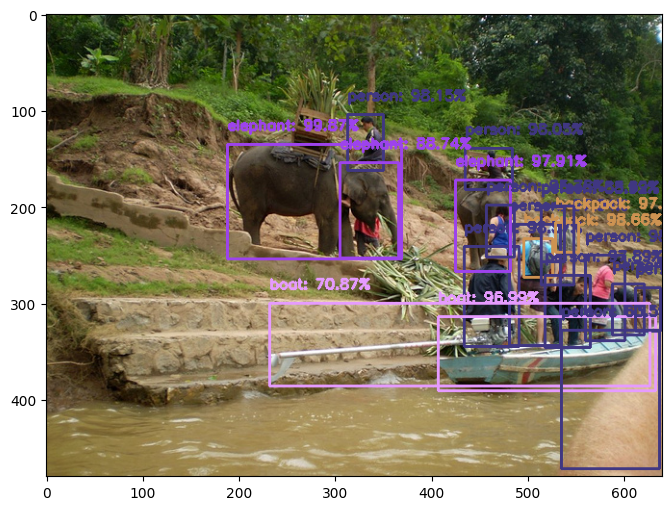

In [10]:
# Label list: https://github.com/amikelive/coco-labels
CLASSES = ['none', 'person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'trafficlight', 'firehydrant', 'streetsign', 'stopsign', 'parkingmeter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eyeglasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sportsball', 'kite', 'baseballbat', 'baseballglove', 'skateboard', 'surfboard', 'tennisracket', 'bottle', 'plate', 'wineglass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hotdog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'mirror', 'diningtable', 'window', 'desk', 'toilet', 'door', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cellphone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddybear', 'hairdrier', 'toothbrush', 'hairbrush']

# Random colors for each detection
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# Iterate along the detections
for i in range(0, len(detections["boxes"])):
    # Obtém a confidencia (probabilidade) assiciada à predição.
    confidence = detections["scores"][i]
    # print(confidence)
    
    # Filtra objetos detectados com confidencia <= CONFIDENCE
    if confidence > CONFIDENCE:
        # Obtém o indice da classe
        idx = int(detections["labels"][i])

        # Calcula as coordenadas do bounding-box
        box = detections["boxes"][i].detach().cpu().numpy()
        (startX, startY, endX, endY) = box.astype("int")
        
        # Gera o rótulo dos objetos
        label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
        print("[INFO] {}".format(label))
        
        # Desenha os bounding-boxes dos objetos detectados
        cv2.rectangle(image_orig, (startX, startY), (endX, endY), COLORS[idx], 2)
        # Desenha os rótulos dos objetos detectados
        y = startY - 15 if startY - 15 > 15 else startY + 15
        cv2.putText(image_orig, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)
        
# Plata a imagem com os objetos detectados
plt.figure(figsize=(9, 6))
plt.imshow(image_orig)

## Bibliography
---

* Adrian Rosebrock. ***PyTorch object detection with pre-trained networks.***
    * https://pyimagesearch.com/2021/08/02/pytorch-object-detection-with-pre-trained-networks/
* COCO dataset
    * https://blog.roboflow.com/coco-dataset/
* Script para baixar o COCO dataset.
    * https://github.com/ultralytics/yolov5/blob/master/data/scripts/get_coco.sh